# General Utility Stuff

In [3]:
# fully expand cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import pprint
pd.set_option('display.expand_frame_repr', False)
%matplotlib inline

In [4]:
cache_loc = "./CAPES_Cache"
department_list = []
for root, dirs, files in os.walk(cache_loc):
    for f in files:
        department_list.append(f.split("_")[1])
department_list = list(set(department_list))
master_blacklist = ["FILM","MUIR","SXTH","WARR","CONT","REV","ERC","WCWP", "CAT", "MMW", "SOE", "DOC", "SDCC", "TMC", "HMNR"] 

general_dept_list = [x for x in department_list if (x not in master_blacklist)]

STEM_dept_list = ["PHYS","CENG","CHEM", "BENG","MATH", "ECON", "MAE", "ECE","CSE","COGS","FPMU","SE","NENG","ESYS","PSYC","BIOL","SIO","ENVR"]

non_STEM_dept_list = [x for x in department_list if (x not in master_blacklist+STEM_dept_list)]


def generate_depts_df(dept_list_to_use):
    department_df = pd.DataFrame()
    for dept in dept_list_to_use:
        df = pd.read_pickle(os.path.join(cache_loc,"cape_{}_auto_df.pkl".format(dept)))
        df["Department"] = dept
        department_df = department_df.append(df)
    return department_df


def to_readable_dept_name(dept_name):
    depts = ['TWS', 'BIOL', 'RSM', 'MUS', 'COMM', 'ECON', 'CHIN', 'NENG', 'CGS', 'LAWS', 'USP', 'ETHN', 'EDS', 'BENG', 'LING', 'SOC', 'RELI', 'VIS', 'FPMU', 'HUM',
             'PSYC', 'PHIL', 'STPA', 'COGS', 'ECE', 'ANTH', 'CENG', 'MATH', 'INTL', 'CHEM', 'ICAM', 'SIO', 'THEA', 'HIST', 'PHYS', 'JUDA', 'LATI', 'POLI', 'ESYS',
             'CSE', 'LIT', 'JAPN', 'HDP', 'MAE', 'ENVR', 'SE']
    readable = ['3rd\nWorld\nStudies', "Biology", "Rady\nSchool\nof Mgmt", "Music", "Communi-\ncations","Economics","Chinese","Nano\nEngineering","Gender\nStudies", "Law", "Urban\nStudies","Ethnic\nStudies","Education\nStudies", "Biology\nEngineering", "Linguistics",
               "Sociology", "Religion", "Visual\nArts", "Medicine", "Humanities", "Psychology", "Phil-\nosophy", "Sci-tech\nPublic\nAffairs", "Cognitive\nScience", "ECE", "Anthro-\npology", "Chemical\nEngineering", "Math", "Inter-\nnational\nStudies", "Chemistry",
               "Comp.\nArts", "Scripps\nOceanography", "Theatre","History","Physics","Judaic\nStudies", "Latin\nAmerican\nStudies", "Political\nScience", "Environmental\nSystems","CSE","Liter-\nature", "Japanese", "Human\nDev.",
               "Mech. &\nAero.\nEngineering", "Environmental\nStudies", "Structural\nEngineering"]
    
    convert_dict = {depts[i]:readable[i] for i in range(len(depts))}
    return convert_dict[dept_name]

# General Cape Statistics

In [460]:
# Countingtotal number of courses and profs in capes database, separating based on stem and non-stem
for name, dept_list_to_use in [["STEM",STEM_dept_list], ["Non-STEM",non_STEM_dept_list]]:

    print('\n'+name)
    department_df = generate_depts_df(dept_list_to_use)
    
    total_classes = len(department_df)
    print("Total # of courses recorded: {}".format(total_classes))
    total_profs = len(set(department_df["Instructor"]))
    print("Total # of professors recorded: {}".format(total_profs))




STEM
Total # of courses recorded: 16247
Total # of professors recorded: 1967

Non-STEM
Total # of courses recorded: 15021
Total # of professors recorded: 1747


In [459]:
# calculating response rate, separating based on summer session vs school year
for name, rule in [["Total", lambda x: True], ["School Year", lambda x: x[:2] not in ["S1", "S2", "S3"]], ["Summer Session", lambda x: x[:2] in ["S1", "S2", "S3"]] ]:
    department_df = generate_depts_df(general_dept_list)
    department_df = department_df[department_df["Term"].apply(rule)]
    mean_respond_rate = np.average(department_df["EvalsMade"]/department_df["Enroll"])
    median_respond_rate = np.median(department_df["EvalsMade"]/department_df["Enroll"])
    std_respond_rate = np.std(department_df["EvalsMade"]/department_df["Enroll"])
    print("\n")
    print("{} mean response rate: {}".format(name, mean_respond_rate))
    print("{} median response rate: {}".format(name, median_respond_rate))
    print("{} response rate std: {}".format(name, std_respond_rate))



Total mean response rate: 0.5136955079444511
Total median response rate: 0.46783851155140954
Total response rate std: 0.2043452016237842


School Year mean response rate: 0.5247292982434844
School Year median response rate: 0.47692307692307695
School Year response rate std: 0.1980098960892233


Summer Session mean response rate: 0.40988091106965985
Summer Session median response rate: 0.3333333333333333
Summer Session response rate std: 0.23198582586640054


# Department-Based Boxplots

In [465]:
# https://deparkes.co.uk/2016/11/04/sort-pandas-boxplot/
def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    #return df2[meds.index].boxplot(rot=rot, return_type="axes", figsize=(35,10), fontsize=13)
    return df2[meds.index]

In [468]:
def generate_boxplots(dept_list_to_use):
    
    department_df = generate_depts_df(dept_list_to_use)

    fig, axes = plt.subplots(4,1, figsize=(35,7*4))
    y_labels = ["Avg. Class Recommend %", "Avg. Instructor Recommend %", "Avg. Hours Studied Per Week", "Avg. Grade Received"]
    for i,criteria in enumerate(["RcmndClass", "RcmndInstr", "StudyHrs/wk", "AvgGradeReceived"]):
        df2 = boxplot_sorted(department_df[["Department",criteria]],"Department", criteria)
        boxplot = df2.boxplot(figsize=(35,6), fontsize=13, ax = axes.flatten()[i])
        #axes.flatten()[i].set_xlabel("UCSD Department", fontsize = 20)
        axes.flatten()[i].set_ylabel(y_labels[i], fontsize = 20)
        print("{}: Mean:{} Median:{} Std. Dev.:{}".format(criteria, department_df[criteria].mean(), department_df[criteria].median(), department_df[criteria].std()))
        axes.flatten()[i].set_xticklabels([to_readable_dept_name(x.get_text()) for x in axes.flatten()[i].get_xticklabels()])

RcmndClass: Mean:86.37433372314888 Median:89.0 Std. Dev.:11.986645943616944
RcmndInstr: Mean:84.55184341724625 Median:89.7 Std. Dev.:16.350849205645627
StudyHrs/wk: Mean:6.681764017972548 Median:6.3 Std. Dev.:2.524287380328084
AvgGradeReceived: Mean:3.0629679325413917 Median:3.03 Std. Dev.:0.3745939149941076


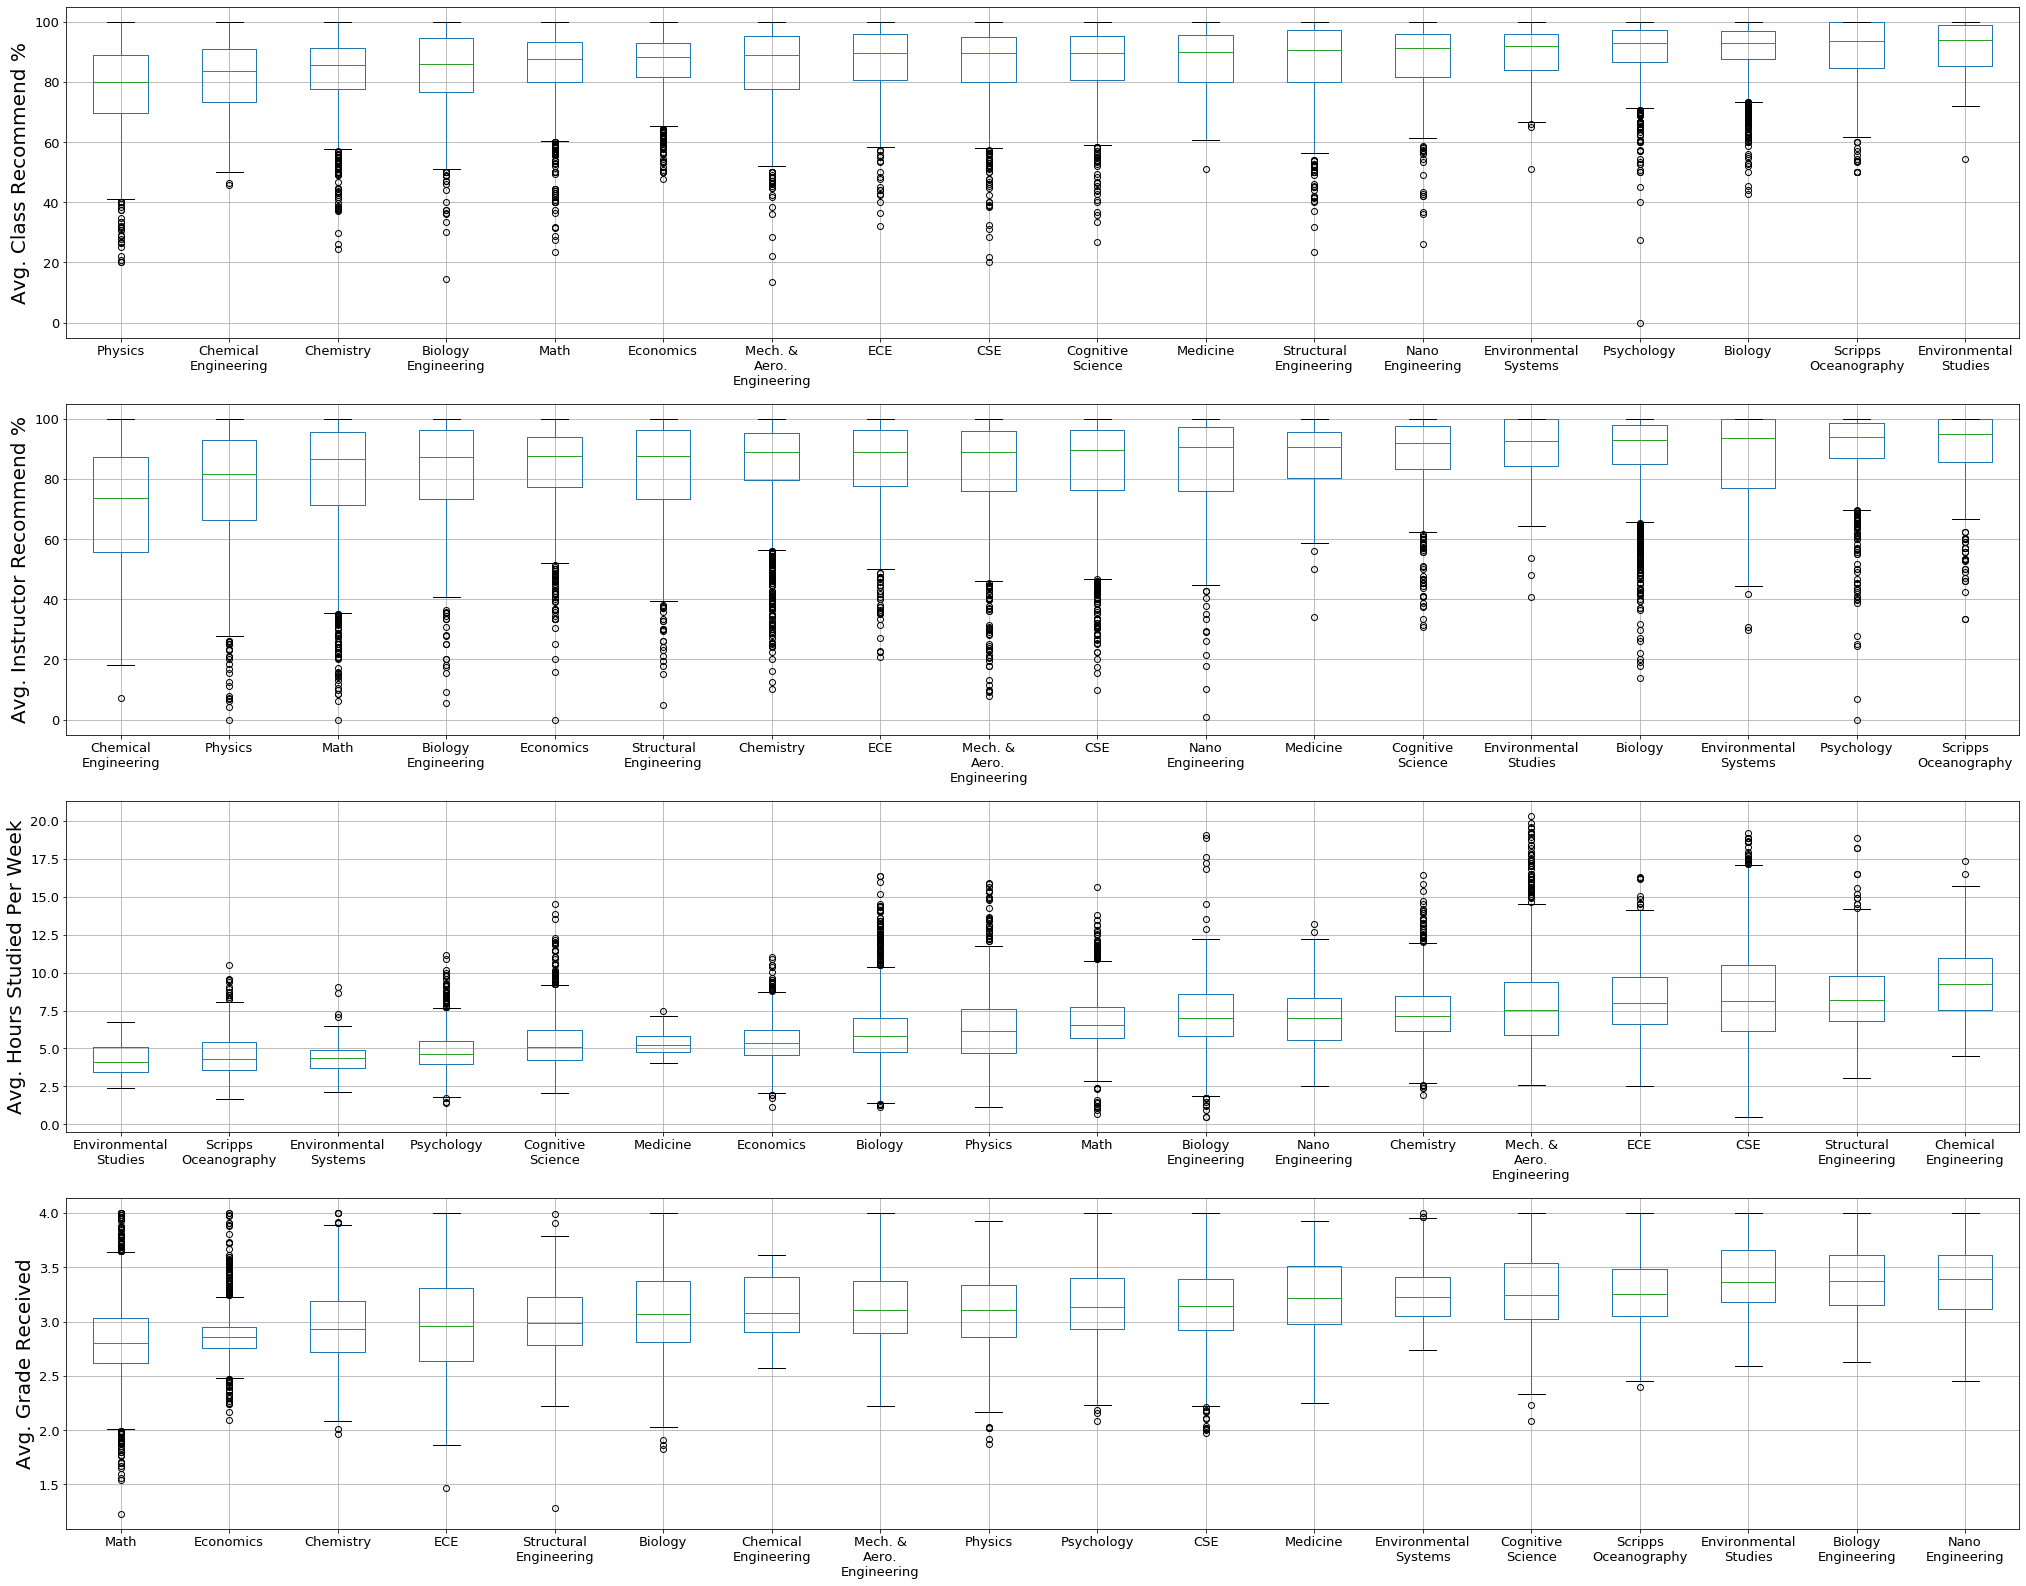

In [469]:
generate_boxplots(STEM_dept_list)

RcmndClass: Mean:90.09769655815192 Median:93.3 Std. Dev.:11.50564141226601
RcmndInstr: Mean:90.6455895080221 Median:94.7 Std. Dev.:12.434284945163931
StudyHrs/wk: Mean:4.7271353438519395 Median:4.57 Std. Dev.:1.6777740157896668
AvgGradeReceived: Mean:3.403666866387058 Median:3.42 Std. Dev.:0.34419916402272316


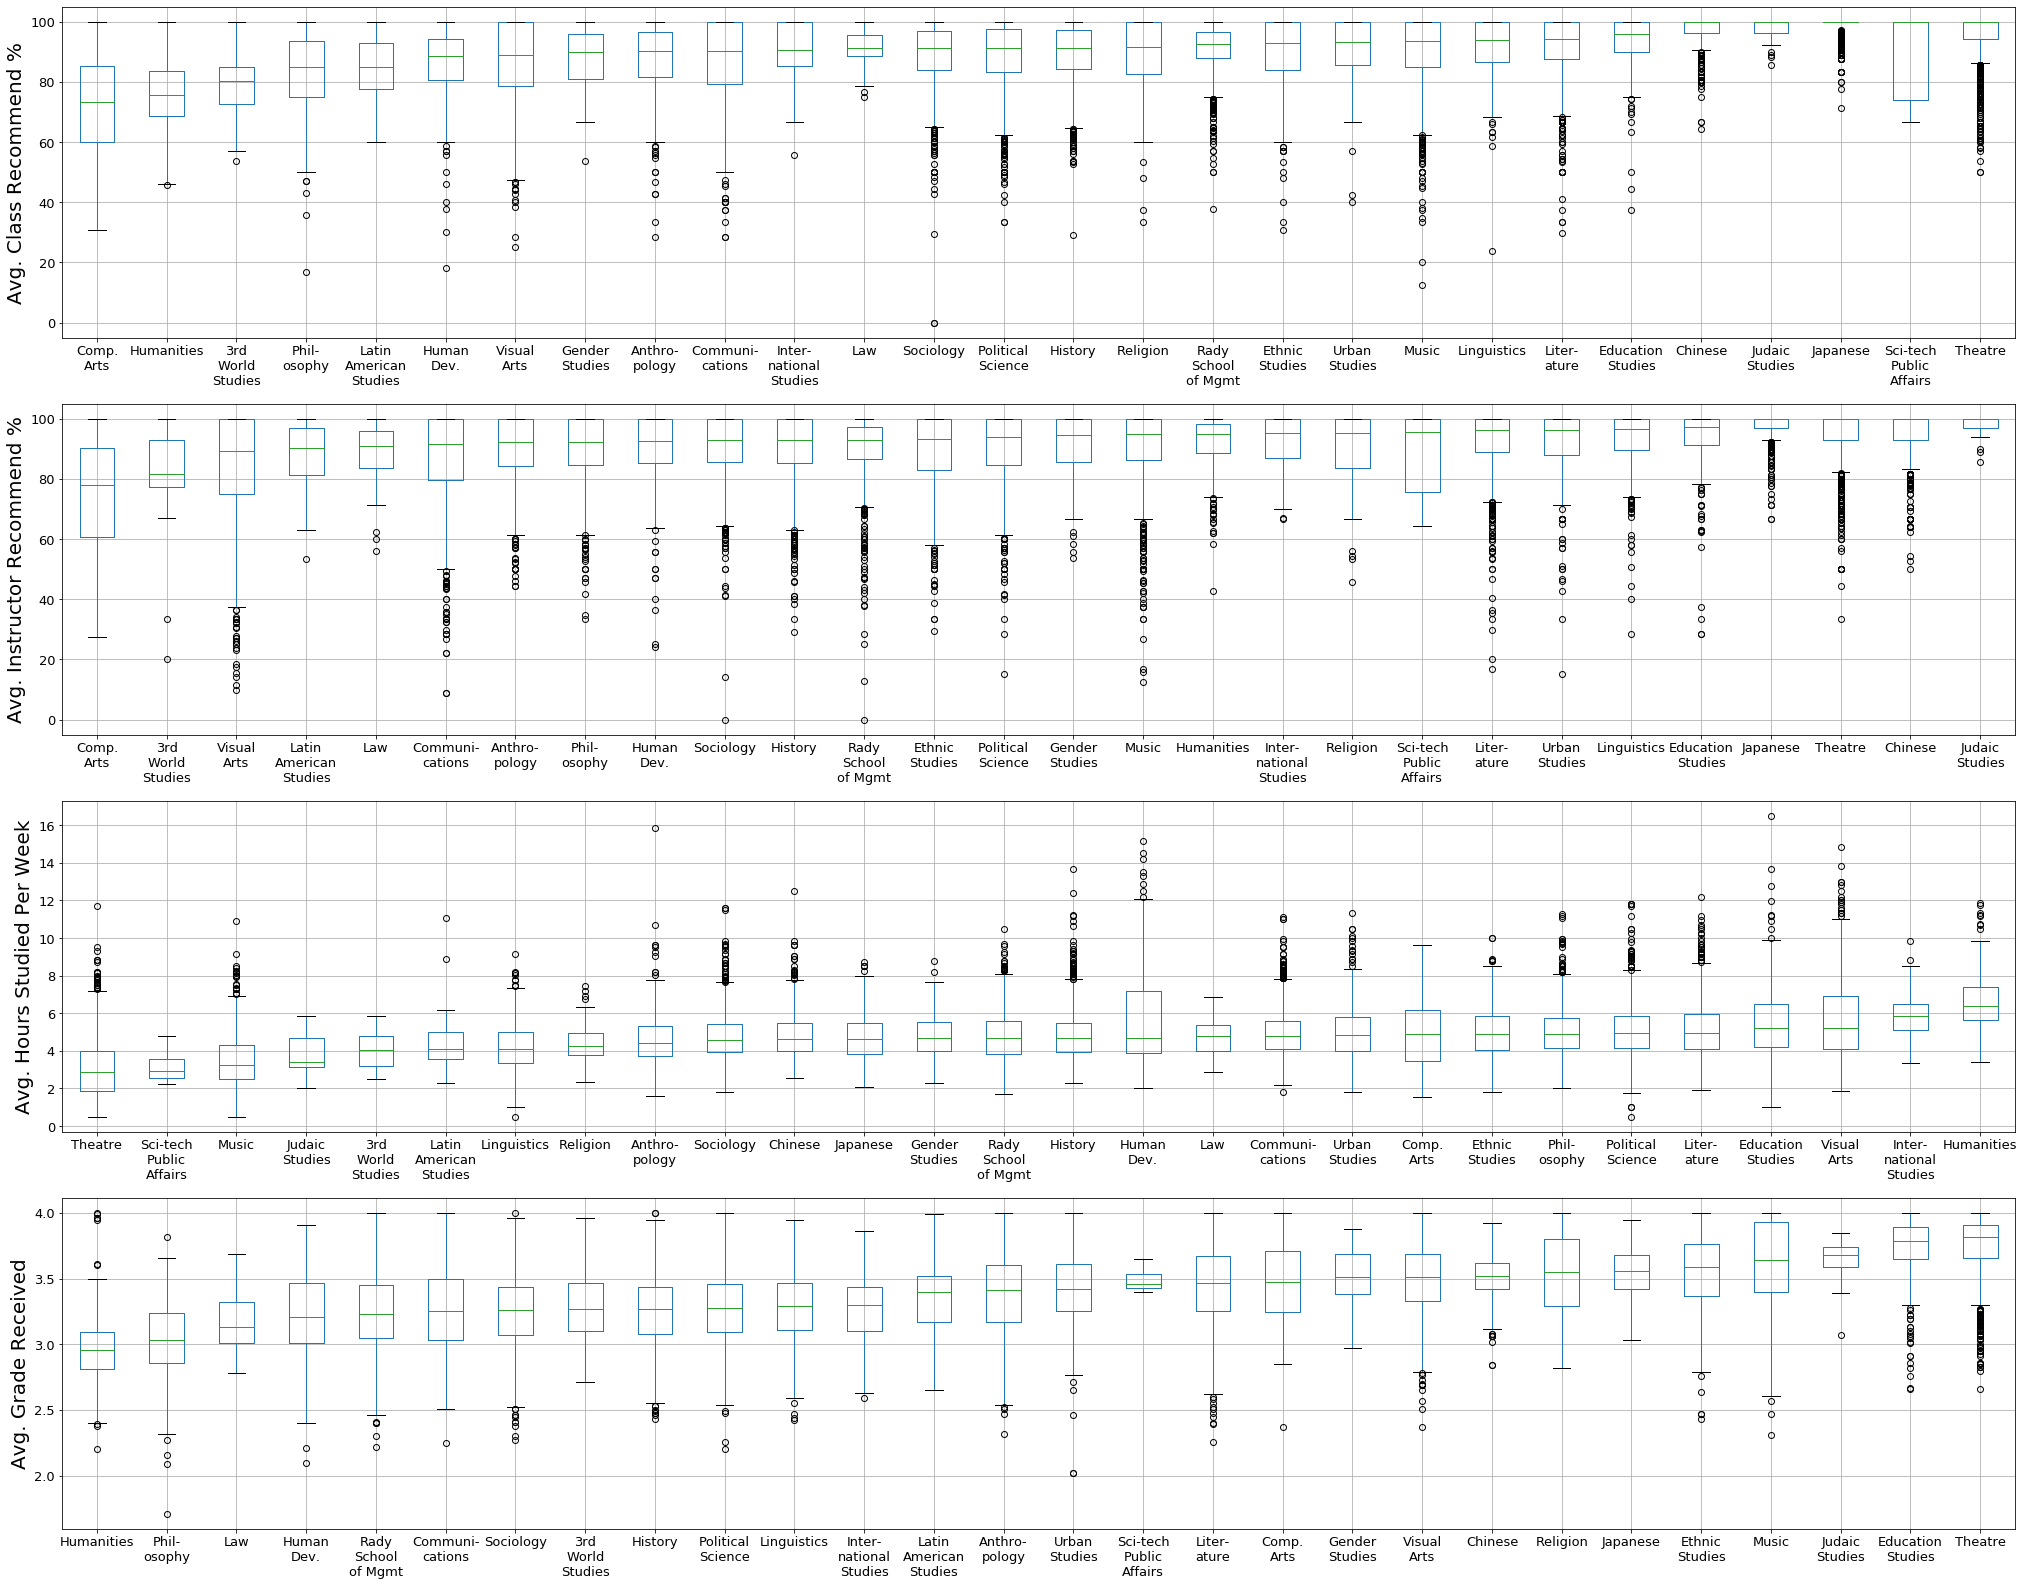

In [470]:
generate_boxplots(non_STEM_dept_list)

# Correlation Analysis

In [544]:

def corr_plots(depts_of_interest, comp_criteria, per_dept_plot):
    corrs = pd.DataFrame(columns=["Dept","Corr"])

    for dept in depts_of_interest:
        dept_df = pd.read_pickle(os.path.join(cache_loc,"cape_{}_auto_df.pkl".format(dept))) 
        correlation_matrix = dept_df[[comp_criteria[0][0], comp_criteria[1][0]]].corr()
        correlation = correlation_matrix.values[0][1]
        corrs = corrs.append({"Dept":dept,"Corr":correlation}, ignore_index=True)
        if per_dept_plot:
            ax = dept_df.plot.scatter(x=comp_criteria[0][0], y=comp_criteria[1][0], title = dept + " Department", figsize=(10,6), fontsize=20)
            ax.set_xlabel(comp_criteria[0][1], fontsize = 14)
            ax.set_ylabel(comp_criteria[1][1], fontsize = 14)

    # plotting barplot of correlations
    print(corrs.sort_values(["Corr"]))
    ax = corrs.sort_values(["Corr"]).plot.bar(x="Dept",y="Corr",figsize=(20,5),fontsize=13, legend=False)
    ax.set_ylabel = ("Pearson Correlation Coefficient")
    ax.set_xticklabels([to_readable_dept_name(x.get_text()).replace('-\n','').replace('\n',' ').replace("Engineering", "Eng.").replace("Studies","Sdy.") for x in ax.get_xticklabels()])

    # plotting scatterplot of all correlations
 
    department_df = generate_depts_df(depts_of_interest)
    ax = department_df.plot.scatter(x=comp_criteria[0][0], y=comp_criteria[1][0], figsize=(10,6), fontsize=20)
    ax.set_xlabel(comp_criteria[0][1], fontsize = 14)
    ax.set_ylabel(comp_criteria[1][1], fontsize = 14)
    print(department_df[[comp_criteria[0][0], comp_criteria[1][0]]].corr())

    Dept      Corr
35  JUDA -0.189175
0    TWS  0.055376
26  CENG  0.060243
36  LATI  0.077363
41  JAPN  0.126696
6   CHIN  0.137709
7   NENG  0.160996
45    SE  0.165453
40   LIT  0.166859
11  ETHN  0.218602
12   EDS  0.229480
16  RELI  0.231964
20  PSYC  0.245848
25  ANTH  0.253395
19   HUM  0.255168
32  THEA  0.257630
10   USP  0.269741
44  ENVR  0.270809
14  LING  0.275297
5   ECON  0.280257
9   LAWS  0.291313
4   COMM  0.293809
34  PHYS  0.298404
8    CGS  0.303628
29  CHEM  0.307482
21  PHIL  0.310594
43   MAE  0.312284
15   SOC  0.315334
27  MATH  0.315433
33  HIST  0.317024
23  COGS  0.319634
13  BENG  0.325843
17   VIS  0.326947
37  POLI  0.338445
1   BIOL  0.352000
2    RSM  0.357046
28  INTL  0.370043
39   CSE  0.376687
18  FPMU  0.391030
31   SIO  0.399234
24   ECE  0.414100
38  ESYS  0.429895
42   HDP  0.435260
30  ICAM  0.493621
3    MUS  0.582422
22  STPA  0.958497
                  RcmndInstr  AvgGradeExpected
RcmndInstr          1.000000          0.367273
AvgGradeExpec

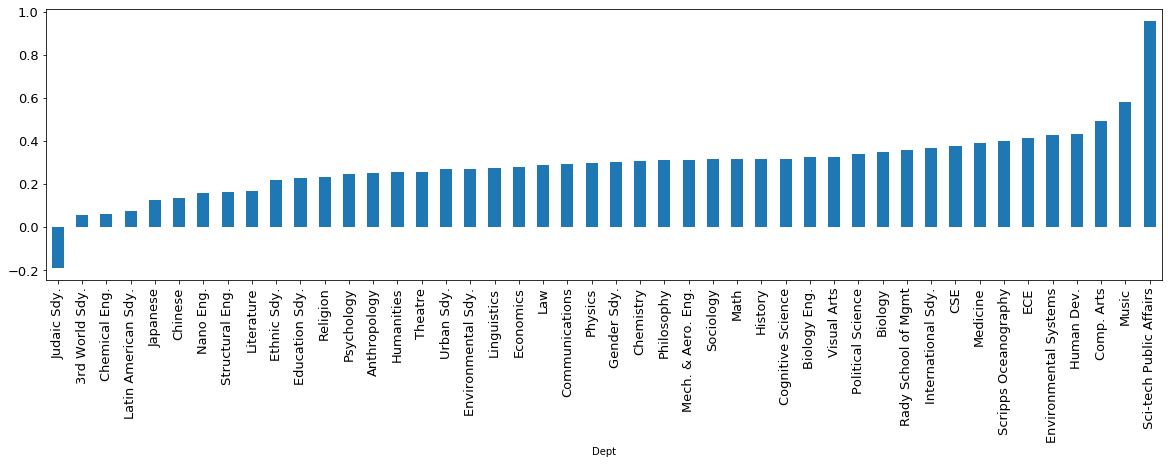

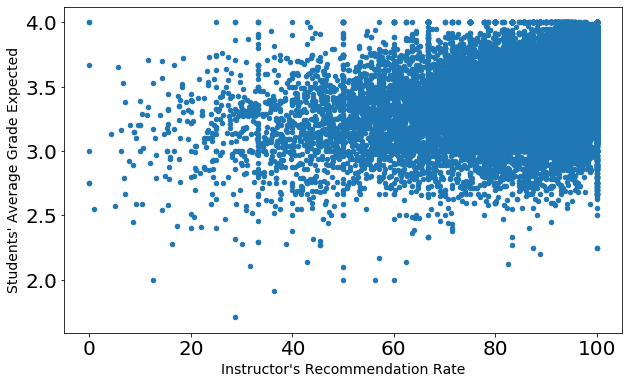

In [543]:
corr_plots(general_dept_list, [["RcmndInstr","Instructor's Recommendation Rate"],["AvgGradeExpected","Students' Average Grade Expected"]], False)

   Dept      Corr
1  JUDA -0.189175
0  CENG  0.060243
2   ECE  0.414100
                  RcmndInstr  AvgGradeExpected
RcmndInstr            1.0000            0.3617
AvgGradeExpected      0.3617            1.0000


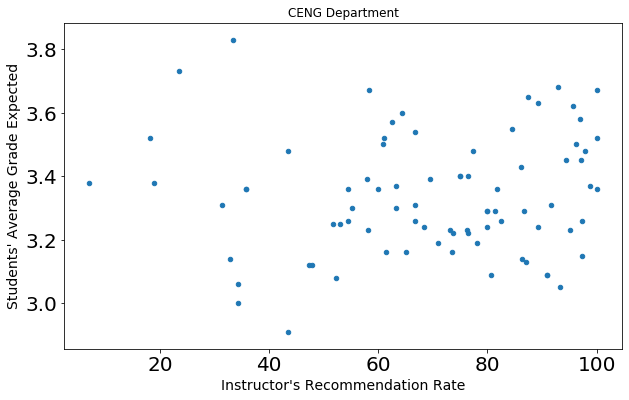

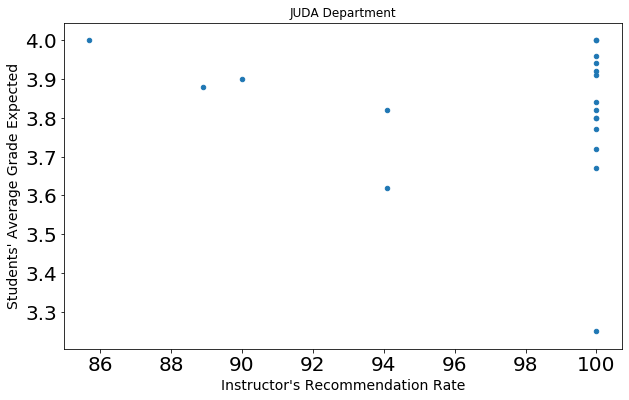

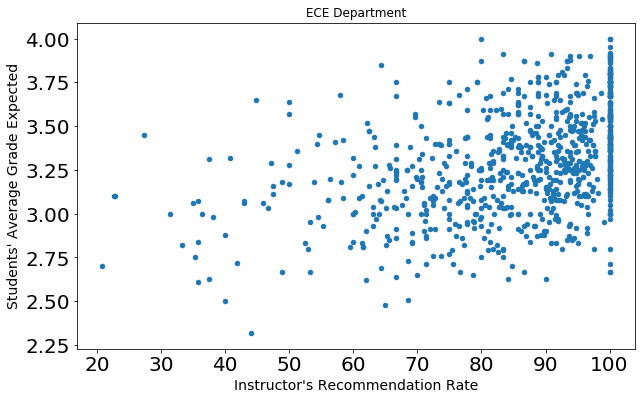

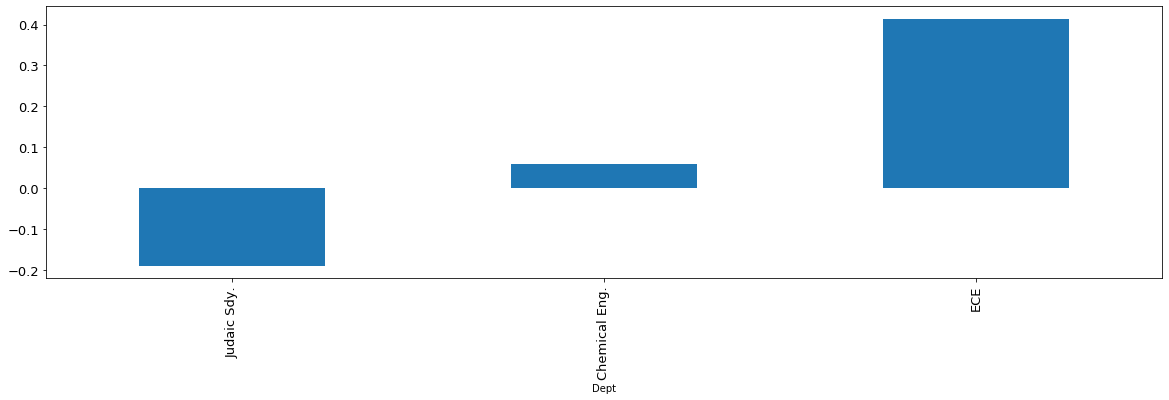

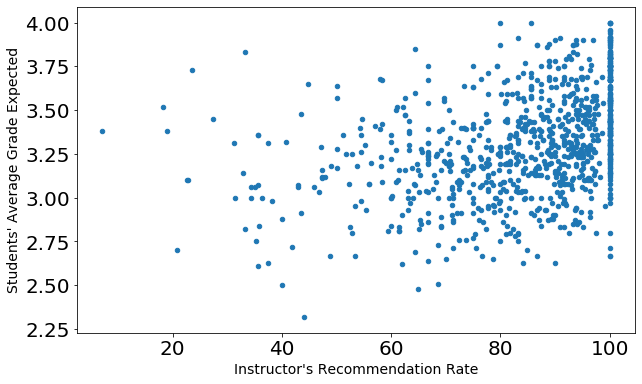

In [542]:
corr_plots(["CENG", "JUDA", "ECE"], [["RcmndInstr","Instructor's Recommendation Rate"],["AvgGradeExpected","Students' Average Grade Expected"]], True)

    Dept      Corr
22  STPA -0.719883
18  FPMU -0.426689
3    MUS -0.247076
26  CENG -0.195068
2    RSM -0.194903
23  COGS -0.162386
12   EDS -0.154543
0    TWS -0.149697
1   BIOL -0.117201
14  LING -0.104070
32  THEA -0.101859
24   ECE -0.088345
31   SIO -0.068744
35  JUDA -0.064330
42   HDP -0.056931
13  BENG -0.036892
37  POLI -0.030603
15   SOC -0.014272
25  ANTH -0.001425
29  CHEM  0.006138
41  JAPN  0.012539
33  HIST  0.013769
5   ECON  0.018032
6   CHIN  0.020906
34  PHYS  0.022376
21  PHIL  0.027907
39   CSE  0.038892
20  PSYC  0.043374
27  MATH  0.043949
45    SE  0.046903
43   MAE  0.053663
4   COMM  0.068163
8    CGS  0.073543
28  INTL  0.087279
17   VIS  0.101372
16  RELI  0.105367
10   USP  0.118185
40   LIT  0.121258
44  ENVR  0.127907
19   HUM  0.152622
7   NENG  0.159115
38  ESYS  0.198033
11  ETHN  0.239083
30  ICAM  0.270811
36  LATI  0.336909
9   LAWS  0.447760
             RcmndInstr  StudyHrs/wk
RcmndInstr     1.000000    -0.134794
StudyHrs/wk   -0.134794     1.000

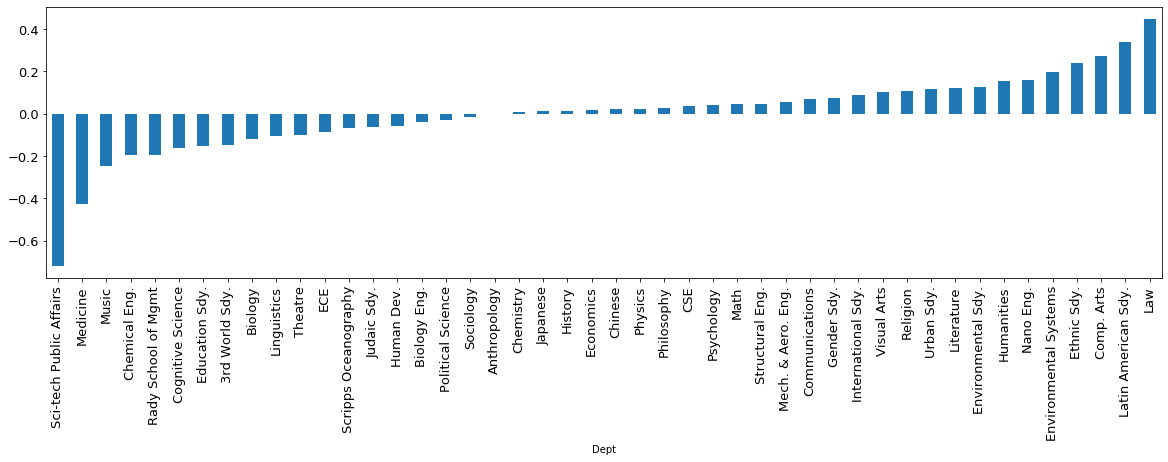

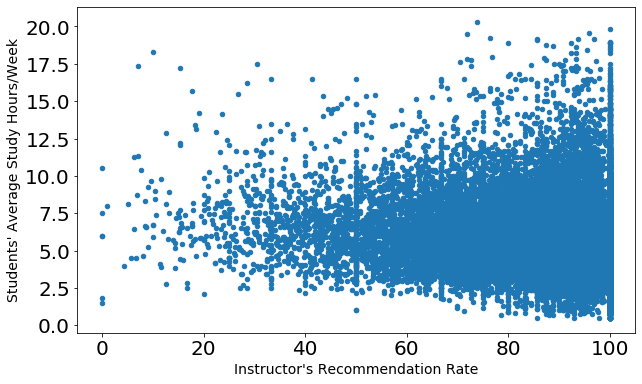

In [545]:
corr_plots(general_dept_list, [["RcmndInstr","Instructor's Recommendation Rate"], ["StudyHrs/wk", "Students' Average Study Hours/Week"]], False)

# Grade Expected vs Received

m:0.9846724659109578, c:-0.1875971609842696


/data7/drone_machinelearning/anaconda3/envs/pytorch11_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


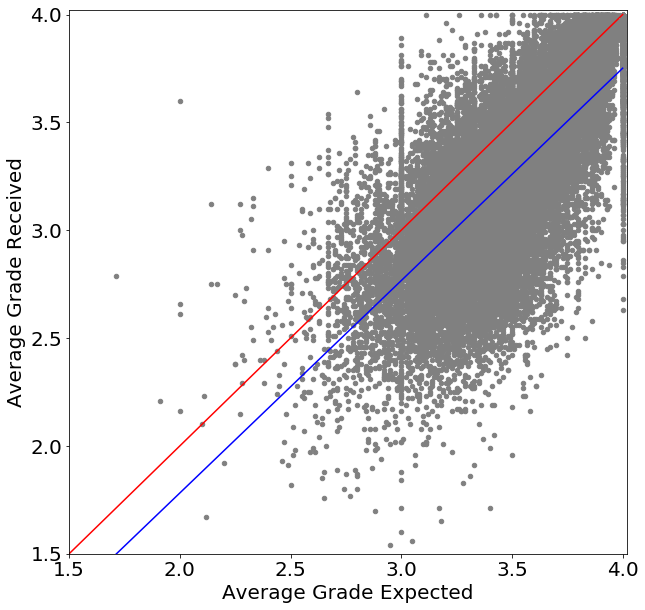

In [483]:
# plotting scatterplot of grades expected and grade received
department_df = generate_depts_df(general_dept_list)
comp_criteria = ["AvgGradeExpected","AvgGradeReceived"]
lower_bound = 1.5
upper_bound = 4.02
ax = department_df.plot.scatter(x=comp_criteria[0], y=comp_criteria[1], c= "grey",ylim=(lower_bound,upper_bound),xlim=(lower_bound,upper_bound), figsize=(10,10), fontsize=20)
ax.set_xlabel("Average Grade Expected", fontsize = 20)
ax.set_ylabel("Average Grade Received", fontsize = 20)

# computing least squares best fit line
y = department_df["AvgGradeReceived"]
x = department_df["AvgGradeExpected"]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print("m:{}, c:{}".format(m,c))


ax.plot(np.linspace(lower_bound,4,10),np.linspace(lower_bound,4,10),c="red")
ax.plot(np.linspace(lower_bound,4,10),(np.linspace(lower_bound,4,10)*m) + c,c="blue")

# Salary vs Instructor Rating

In [20]:
merged_data_dir = "../data/Merged Data"
dept_list_to_use = general_dept_list



combined_df = pd.DataFrame(columns = ["Instructor", "Title", "GrossPay", "RegularPay", "OvertimePay", "OtherPay", ])
for root, dirs, files in os.walk(merged_data_dir):
    for f in files:
        if f[-3:]=='csv' and f.split("_")[1].split('.')[0] in dept_list_to_use:
            print(f)
            df = pd.read_csv(os.path.join(root,f))
            print(df)
            break

Merged_EDS.csv
       SNo  Year   Location       FirstName        LastName               Title    GrossPay  RegularPay  OvertimePay   OtherPay  ...              Instructor                                  Course  Term Enroll  EvalsMade  RcmndClass RcmndInstr StudyHrs/wk  AvgGradeExpected AvgGradeReceived
0    20378  2018  San Diego      THANDEKA K         CHAPMAN       ASSOC PROF-AY  116,817.00  116,817.00          0.0       0.00  ...       Chapman,ThandekaK            EDS112-U.S.UrbanEducation(A)  WI19     57         21       94.7%      94.7%        2.29          A-(3.88)         A-(3.79)
1    20378  2018  San Diego      THANDEKA K         CHAPMAN       ASSOC PROF-AY  116,817.00  116,817.00          0.0       0.00  ...       Chapman,ThandekaK            EDS112-U.S.UrbanEducation(A)  WI18     53         24      100.0%     100.0%        3.25          A-(3.82)         A-(3.83)
2    20378  2018  San Diego      THANDEKA K         CHAPMAN       ASSOC PROF-AY  116,817.00  116,817.00         

In [28]:
merged_data_dir = "../data/Merged Data"
prof_df = pd.DataFrame()
for dept in dept_list_to_use:
    avg_prof_df = pd.read_pickle(os.path.join(cache_loc,"cape_{}_auto_df_prof.pkl".format(dept)))
    merged_salary_df = pd.read_csv(os.path.join(merged_data_dir,"Merged_{}.csv".format(dept)))
    # appending salary info
    for prof in merged_salary_df["Instructor"]:
        print(prof)
    #df["Department"] = dept
    #prof_df = prof_df.append(df)
    break

Alexander,AmyJ
Alexander,AmyJ
Alexander,AmyJ
Alexander,AmyJ
Almeida,Jane
Brown,SheldonGlenn
Brown,SheldonGlenn
Brown,SheldonGlenn
Brown,SheldonGlenn
Dubnov,Shlomo
Dubnov,Shlomo
Park,KyongDong


In [186]:
#pd.options.mode.chained_assignment = None 
dept_list_to_use = general_dept_list
#dept_list_to_use = ["ICAM", "ENVR", "COGS", "JAPN"]
#dept_list_to_use = ["ECE"]
title_dict = {}
total_df = pd.DataFrame(columns = ["Title","GrossPay", "RegularPay", "OvertimePay", "OtherPay", "Instructor", "Enroll", "EvalsMade", "RcmndInstr"])
corrs = pd.DataFrame(columns=["Dept","Corr"])
for root, dirs, files in os.walk(merged_data_dir):
    for f in files:
        dept = f.split("_")[1].split('.')[0]
        if f[-3:]=='csv' and dept in dept_list_to_use:
            averaged_df = pd.DataFrame(columns = ["Title","GrossPay", "RegularPay", "OvertimePay", "OtherPay", "Instructor", "Enroll", "EvalsMade", "RcmndInstr"])
            df = pd.read_csv(os.path.join(root,f))
            df = df[df["Term"].apply(lambda x : x[-2:] in ['17','18','19'])]
            df = df.drop(labels=["SNo","Year","Location","FirstName","LastName","fullName", "StudyHrs/wk", "AvgGradeExpected", "AvgGradeReceived", "RcmndClass", "Course", "Term"], axis = 1)
            # getting rid of percentage
            df["RcmndInstr"] = df["RcmndInstr"].apply(lambda x:float(x[:-1]))
            df["GrossPay"] = df["GrossPay"].apply(lambda x:float(x.replace(",","")))
            for prof in set(df["Instructor"]):
                prof_df = df[df["Instructor"]==prof]
                prof_weighted_rcmnd = sum(prof_df["EvalsMade"]*prof_df["RcmndInstr"])/sum(prof_df["EvalsMade"])
                prof_row = prof_df.iloc[0]
                prof_row["Enroll"] = sum(prof_df["Enroll"])
                prof_row["EvalsMade"] = sum(prof_df["EvalsMade"])
                prof_row["RcmndInstr"] = prof_weighted_rcmnd
                averaged_df = averaged_df.append(prof_row)
            if len(averaged_df)>0:
                #ax = averaged_df[["GrossPay", "RcmndInstr"]].plot.scatter(x="GrossPay", y="RcmndInstr", title = dept)
                corr = averaged_df[["GrossPay", "RcmndInstr"]].corr().values[1][0]
                corrs = corrs.append({"Dept":dept,"Corr":corr}, ignore_index=True)
            total_df = total_df.append(averaged_df)
print(total_df)
#print(corrs.sort_values("Corr"))



                            Title  GrossPay  RegularPay OvertimePay    OtherPay               Instructor Enroll EvalsMade  RcmndInstr
109            LECT-AY-CONTINUING  138170.0  122,970.00           0   15,200.00    Millstone,RachelDiana     94        64  100.000000
41                        LECT-AY  108520.0   92,892.00           0   15,628.00         Heinzman,EricaM.    208       184   98.801630
126                   LECT-AY-1/9   15600.0   15,600.00           0        0.00           Page,RachelLys     45        21   81.000000
15                   ASST PROF-AY  112875.0   84,175.00           0   28,700.00             Cohen,ShanaR    163        82   89.801220
0                   ASSOC PROF-AY  116817.0  116,817.00           0        0.00        Chapman,ThandekaK    231        92   96.279348
30                    LECT-AY-1/9   46877.0   33,556.00           0   13,321.00       Drake,KristyNicole    106       100   97.984000
46             LECT-AY-CONTINUING  148031.0  132,411.00       

In [155]:
set(total_df["Title"])

{'ACAD ACHIEVEMENT CNSLR 2',
 'ACAD PRG MGT OFCR 4',
 'ACADEMIC COORD I-AY',
 'ACADEMIC COORD I-FY',
 'ACADEMIC COORD II-FY',
 'ADJ PROF-AY',
 'ADJ PROF-AY-B/E/E',
 'ADJ PROF-HCOMP',
 'ADMIN OFCR 2',
 'ASC PHYSCN',
 'ASSOC ADJ PROF-HCOMP',
 'ASSOC PROF IN RES-HCOMP',
 'ASSOC PROF OF CLIN-HCOMP',
 'ASSOC PROF-AY',
 'ASSOC PROF-AY-B/E/E',
 'ASSOC PROF-FY',
 'ASSOC PROF-HCOMP',
 'ASSOC PROJ SCIENTIST-FY',
 'ASSOC RES-FY',
 'ASSOC RES-FY-B/E/E',
 'ASSOC VICE CHANC',
 'ASST ADJ PROF-FY',
 'ASST ADJ PROF-HCOMP',
 'ASST PROF-AY',
 'ASST PROF-AY-1/9-B/E/E',
 'ASST PROF-AY-B/E/E',
 'ASST PROF-HCOMP',
 'ASST PROJ SCIENTIST-FY',
 'ASST PROJ SCIENTIST-FY-B/E/E',
 'ASST RES-AY',
 'ASST RES-FY',
 'ASST RES-FY-B/E/E',
 'COLLEGE PROVOST',
 'CONTINUING APPT-TEMP AUG',
 'CURATORIAL MGR 1',
 'DEAN',
 'DIRECTOR',
 'EHS SPEC 2 NEX',
 'FUNDRAISER 4',
 'HOSP BLANK AST 3',
 'HS ASSOC CLIN PROF-FY',
 'HS ASST CLIN PROF-HCOMP',
 'LECT IN SUMMER SESSION',
 'LECT PSOE-AY',
 'LECT SOE-AY',
 'LECT-AY',
 'LECT-AY-1/

In [187]:
# https://www.ucop.edu/academic-personnel-programs/_files/acad-title-codes/academic-titles-tc-sorted-cto.pdf
assoc_prof_df = total_df[total_df["Title"].apply(lambda x : "ASSOC PROF" in x)]
adj_prof_df = total_df[total_df["Title"].apply(lambda x : "ADJ PROF" in x)]
asst_prof_df = total_df[total_df["Title"].apply(lambda x : "ASST PROF" in x)]
lect_prof_df = total_df[total_df["Title"].apply(lambda x : x[:4]=="LECT")]
sr_lect_prof_df = total_df[total_df["Title"].apply(lambda x : "SR LECT" in x)]
full_prof_df = total_df[total_df["Title"].apply(lambda x : x[:4]=="PROF")]

dfs = [assoc_prof_df, adj_prof_df, asst_prof_df, lect_prof_df, sr_lect_prof_df, full_prof_df]

In [188]:
for df in dfs:
    print(len(df))
    print(df["RcmndInstr"].mean())

162
89.4295988760202
11
90.07106490694137
191
86.92861206996241
301
89.91808056335981
8
89.85303815267318
428
83.55480192733278


In [ ]:
prin